In [4]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import imutils
import matplotlib.pyplot as plt
import tensorflow as tf

#### Cropping the images to remove background

In [5]:
def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img

#### Creating a cropped folder in which cropped training and testing images are stored

In [6]:
if __name__ == "__main__":
	training = "Dataset/Trainingbrain"
	testing = "Dataset/Testingbrain"
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 256
	
	for dir in training_dir:
		save_path = 'Dataset/cropped/Training/'+ dir
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)
	
	for dir in testing_dir:
		save_path = 'Dataset/cropped/Testing/'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)


	

In [7]:
training_dir

['glioma', 'meningioma', 'notumor', 'pituitary']

#### Cropped images Demo 

In [8]:
img = cv2.imread('./Dataset/Trainingbrain/meningioma/Tr-me_0476.jpg')
img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

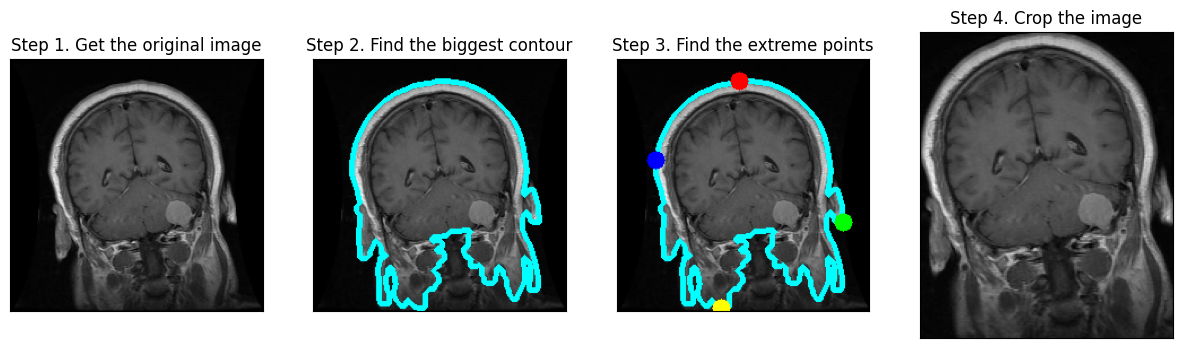

In [9]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [10]:
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 200
labels = ['glioma','meningioma','notumor','pituitary'] 
for i in labels:
    folderpath = os.path.join('./Dataset/Cropped/Training',i)
    for j in os.listdir(folderpath):
        image = cv2.imread(os.path.join(folderpath,j),0) #load images in gray
        image = cv2.bilateralFilter(image,2,50,50) # remove noise image
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images
        X_train.append(image)
        y_train.append(labels.index(i))
        
for i in labels:
    folderpath = os.path.join('./Dataset/Cropped/Testing',i)
    for j in os.listdir(folderpath):
        image = cv2.imread(os.path.join(folderpath,j),0) #load images in gray
        image = cv2.bilateralFilter(image,2,50,50) # remove noise image
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images
        X_test.append(image)
        y_test.append(labels.index(i))

X_train = np.array(X_train) / 255.0 # normalize Images into range 0 to 1.
X_test = np.array(X_test) / 255.0

print(X_train.shape)
print(X_test.shape)
        

(3641, 200, 200, 3)
(893, 200, 200, 3)


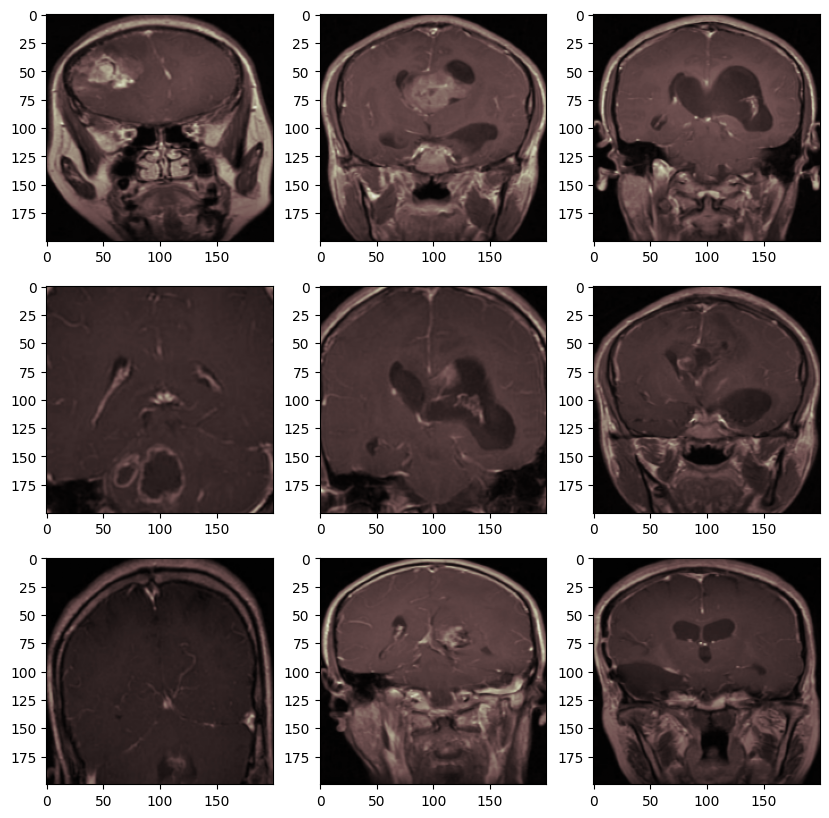

In [11]:
images = [X_train[i] for i in range(9)]
fig, axes = plt.subplots(3, 3, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
#plt.tight_layout()
plt.show()

In [12]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [13]:
X_train, y_train = shuffle(X_train,y_train, random_state=42) 

In [14]:
y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.
print(X_val.shape)
print(X_train.shape)
print(X_test.shape)

(729, 200, 200, 3)
(2912, 200, 200, 3)
(893, 200, 200, 3)


#### Image Augmentation

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam

In [17]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
     rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(X_train)

#### Model Training

In [18]:
from tensorflow.keras.applications.resnet import ResNet50
IMG_SIZE=(200,200)
base_model = ResNet50(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet')

for layer in base_model.layers:
    layer.trainable = True

In [19]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block1_2_relu (Activ  (None, 50, 50, 64)           0         ['conv2_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block1_0_conv (Conv2  (None, 50, 50, 256)          16640     ['pool1_pool[0][0]']          
 D)                                                                                               
                                                                                                  
 conv2_block1_3_conv (Conv2  (None, 50, 50, 256)          16640     ['conv2_block1_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_blo

In [20]:
# Customized layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
predict = Dense(4,activation='softmax')(x)

# create a model object
model = Model(inputs = base_model.input,outputs = predict)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [21]:
#compile our model.
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [22]:
train_len = len(X_train)
val_len = len(X_val)
print("-----------Training Data length-----------------")
print(train_len)

print("-----------Validation Data length-----------------")
print(val_len)

-----------Training Data length-----------------
2912
-----------Validation Data length-----------------
729


In [23]:
hist = model.fit(datagen.flow(X_train, y_train, batch_size=32),validation_data = (X_val,y_val),epochs = 25,verbose=1)

Epoch 1/25


91/91 [==============================] - 623s 6s/step - loss: 0.3405 - accuracy: 0.8743 - val_loss: 3.3600 - val_accuracy: 0.2387
Epoch 2/25
91/91 [==============================] - 510s 6s/step - loss: 0.1052 - accuracy: 0.9639 - val_loss: 4.4684 - val_accuracy: 0.2414
Epoch 3/25
91/91 [==============================] - 498s 5s/step - loss: 0.0727 - accuracy: 0.9760 - val_loss: 6.1329 - val_accuracy: 0.2455
Epoch 4/25
91/91 [==============================] - 502s 6s/step - loss: 0.0345 - accuracy: 0.9870 - val_loss: 7.3390 - val_accuracy: 0.2318
Epoch 5/25
91/91 [==============================] - 495s 5s/step - loss: 0.0487 - accuracy: 0.9835 - val_loss: 6.6957 - val_accuracy: 0.2277
Epoch 6/25
91/91 [==============================] - 501s 5s/step - loss: 0.0618 - accuracy: 0.9804 - val_loss: 6.8028 - val_accuracy: 0.2538
Epoch 7/25
91/91 [==============================] - 490s 5s/step - loss: 0.0382 - accuracy: 0.9883 - val_loss: 5.1833 - val_accuracy: 0.2634
Epoch 8/25


#### Plotting output results

In [24]:
#Plotting the results
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

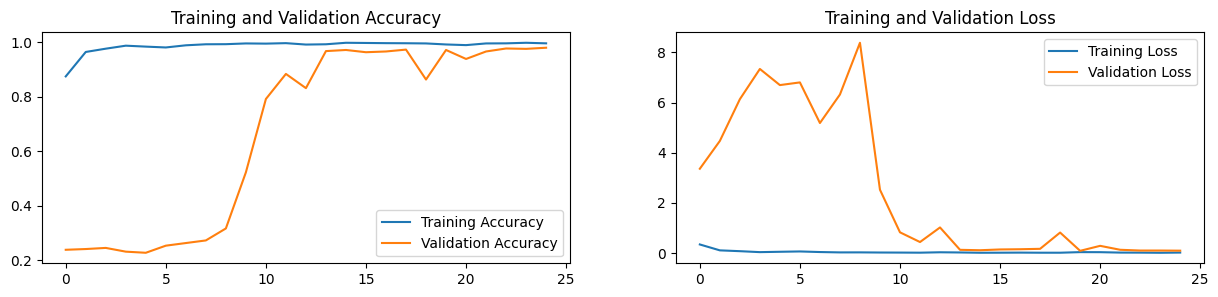

In [25]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend(loc= "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend(loc= "upper right")
plt.title("Training and Validation Loss")

In [26]:
#Saving the model
from keras.models import load_model
model.save('bestresnet.h5')

c:\Users\saras\steffysara\VS_Code_Projects\Potato_Disease_Classifier\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Validation on Test set

In [27]:
loss,acc = model.evaluate(X_test,y_test)

28/28 [==============================] - 43s 2s/step - loss: 0.1403 - accuracy: 0.9731


#### Classification Report

In [28]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_classes = np.argmax(model.predict(X_test), axis = 1)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes,target_names=['glioma','meningioma','no_tumor','pituitary']))

28/28 [==============================] - 42s 1s/step
              precision    recall  f1-score   support

      glioma       0.99      0.95      0.97       209
  meningioma       0.97      0.94      0.96       206
    no_tumor       0.99      1.00      1.00       278
   pituitary       0.93      0.99      0.96       200

    accuracy                           0.97       893
   macro avg       0.97      0.97      0.97       893
weighted avg       0.97      0.97      0.97       893



#### Confusion Matrix

112/112 [==============================] - 45s 402ms/step


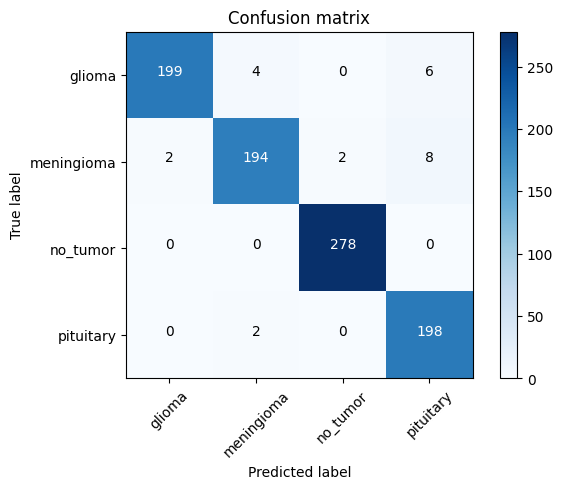

In [29]:
import itertools
pred_Y = model.predict(X_test, batch_size = 8, verbose = True)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names=['glioma','meningioma','no_tumor','pituitary']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test, batch_size=8)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis = 1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4)) 

#### Plotting sample predictions

28/28 [==============================] - 39s 1s/step


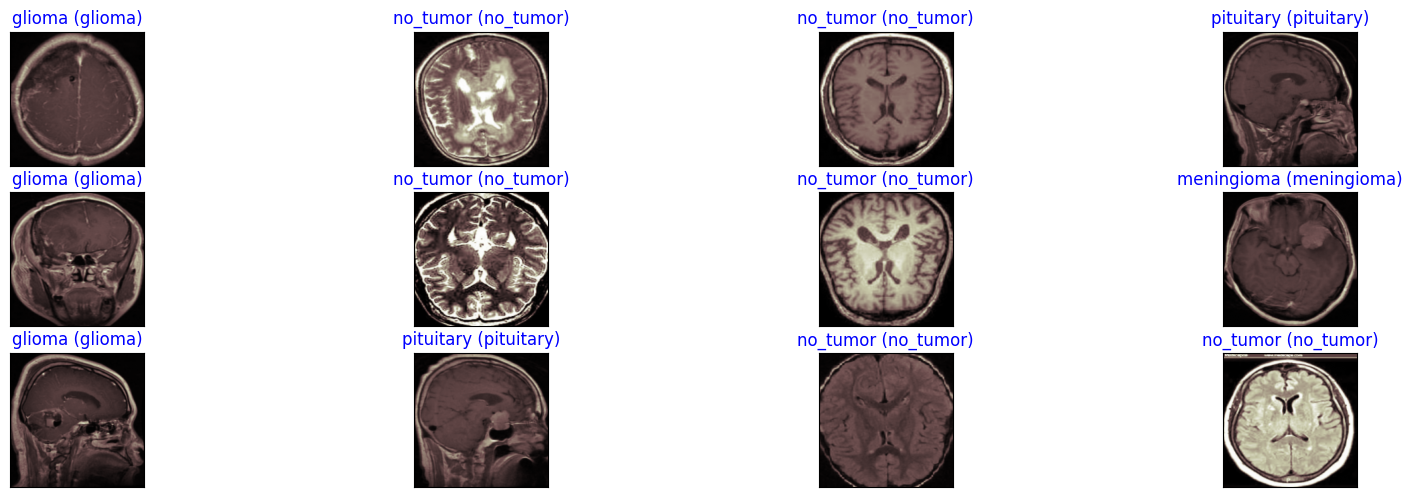

In [30]:
y_hat = model.predict(X_test)

# define text labels 
target_labels = ['glioma','meningioma','no_tumor','pituitary']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))